## Project description

## import modules

In [30]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,fbeta_score

from sklearn.naive_bayes  import GaussianNB
from sklearn.svm import SVC
from  sklearn.ensemble  import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

## load data

In [9]:
with ZipFile('titanic.zip','r') as titanic:
    titanic.extractall()
    titanic.close()

In [139]:
train_df = pd.read_csv('train.csv')

In [146]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [57]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


 with intuition and general knowledege inspect pclass, sex, age with relationship of surivial rate

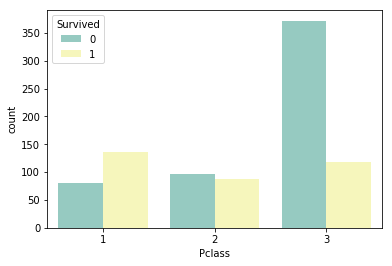

In [69]:
ax1 = sns.countplot(x = 'Pclass',hue = 'Survived',data = train_df,palette="Set3")


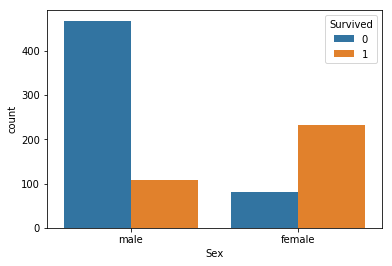

In [70]:
ax2 = sns.countplot(x = 'Sex',hue = 'Survived',data = train_df)

In [97]:
train_df['Sex'] = train_df['Sex'].map({'male':0,'feamale':1})

## Process name column to generate a title column

In [156]:
def split_name(df,col_name,new_name):
    
    miss_ = ['Mlle','Ms','Mme','Lady','theCountess']
    mr_ = ['Don','Rev','Col','Major','Jonkheer','Sir','Capt']
    
#     extract out title frome col_name
    split_arr = df[col_name].str.split(',')
    result = []
    for i in range(len(split_arr)):
         result.append(split_arr[i][1].split('.')[0].replace(' ',''))
#     group the new titles
    for i in range(len(result)):
        if result[i]  in miss_:
            result[i] = 'Miss'
        elif result[i] in mr_:
            result[i] = 'Mr'
    
    df[new_name] = result
    
    return df

In [160]:
split_name(train_df,'Name','Title')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs


In [162]:
split_name(train_df,'Name','Title')['Title'].value_counts()



Mr        531
Miss      188
Mrs       125
Master     40
Dr          7
Name: Title, dtype: int64

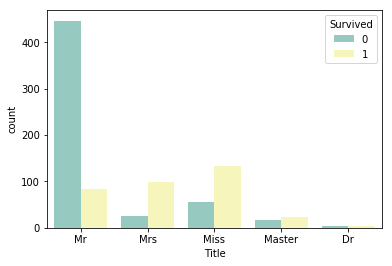

In [165]:
ax2 = sns.countplot(x = 'Title',hue = 'Survived',data = train_df,palette="Set3")

##  One hot enconding for Title columns

In [183]:
pre_train_df = train_df[['Pclass','Title','Survived']]
df_title = pd.get_dummies(pre_train_df['Title'])
pre_df = pd.merge(pre_train_df,df_title,left_index =True,right_index =True)
pre_df.drop('Title',axis = 1,inplace =True)

In [184]:
pre_df.head()

,Pclass,Survived,Dr,Master,Miss,Mr,Mrs
0,3,0,0,0,0,1,0
1,1,1,0,0,0,0,1
2,3,1,0,0,1,0,0
3,1,1,0,0,0,0,1
4,3,0,0,0,0,1,0


##  split dataset as train and valiation

In [177]:
X = pre_df.drop('Survived',axis = 1)
y = pre_df['Survived']

In [212]:
X_train, X_valid, y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state = 42,stratify = y)

In [213]:
sum(y_train ==1) / len(y_train) *100

38.342696629213485

In [214]:
sum(y_valid ==1) / len(y_valid)

0.3854748603351955

##  Evaluating Model Performance

In [ ]:
In this case, model is capable to predict the one survied or not is equally important, then we use f_beta s

## Naieve model